In [524]:
import numpy as np
import collections
import pandas as pd
# for cleaning
import regex as re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.decomposition import PCA
# for tokenizing
from nltk.tokenize import word_tokenize
# vectorize tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# for plots and visuals
import matplotlib.pyplot as plt
import seaborn as sns
import time
# reading file form data directory
import os
# for clustering
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [525]:
# get names of all the files to be clustered
files = os.listdir('/mnt/c/_programming/medius-intern-challenge/ClusterDocs/data')
# ignore the .DS_STORE file
files.remove(files[0])
# store the contents into a list
docsList = []
path = '/mnt/c/_programming/medius-intern-challenge/ClusterDocs/data/'
for file in files:
    p = path+file
    # to handle different encodings
    f = open(p, encoding="ascii", errors="surrogateescape")
    contents = f.read()
    docsList.append(contents)


In [526]:
# parse emails into sender, receiver and body key-value pairs
def parseRawMessage(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'path']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email
def parseEmails(messages):
    emails = [parseRawMessage(message) for message in messages]
    mapp= {'body':[], 'to':[],'_from':[]}
    for email in emails:
        mapp['body'].append(email['body'])
        mapp['to'].append(email['path'])
        mapp['_from'].append(email['from'])
    return mapp


In [527]:
emailDf = pd.DataFrame(parseEmails(docsList))
emailDf

,body,to,_from
0,">Personally, I doubt she said anything of the ...",cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu...,as010b@uhura.cc.rochester.edu (Tree of Schnopia)
1,>->-2. The homosexuals have gotten a law passe...,cantaloupe.srv.cs.cmu.edu!rochester!cornell!ba...,s0xjg@exnet.co.uk (Xavier Gallagher)
2,"| I like the way people call it ""cruel and unu...",cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu...,cj@eno.esd.sgi.com (C.J. Silverio)
3,">>Jack, I happen to be Jewish and have some se...",cantaloupe.srv.cs.cmu.edu!rochester!cornell!ba...,arf@genesis.MCS.COM (Jack Schmidling)
4,In article <1993Apr5.201051.15818@dsd.es.com>W...,cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu...,jmann@vineland.pubs.stratus.com (Jim Mann)
...,...,...,...
295,>>>>> \t LDS and RLDS> philosophy is that all...,cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cm...,awe@pimms.mit.edu (Ari Epstein)
296,>>value gun shops where all the city's many fi...,cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cm...,mjr@tis.com (Marcus J Ranum)
297,> >What did those people do wrong in the first...,cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cm...,cmort@NCoast.ORG (Christopher Morton)
298,>>>> Firearms are the fifth-leading cause of ...,cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cm...,R1328@vmcms.csuohio.edu


In [557]:
# removing empty columns if any
emailDf.drop(email_df.query(
    "body == '' | to == '' | _from == ''"
).index, inplace=True)

In [529]:
# process the body data by removing all punctuations and stop words, then lemmatizing
def cleanText(docsList):
    cleanDocs = []
    # regex patterns for letters, digits, unedrscores
    p1 = re.compile(r'^\W+|\W+$')
    # pattern for newline, tabs, spaces
    p2 = re.compile(r'\s')
    # pattern for punctuations
    p3 = re.compile(r'[^a-zA-Z0-9]')
    lemma = WordNetLemmatizer()
    
    for doc in docsList:
        newToken = ""
        for word in doc.split():
            if (not p1.match(word)) and (not p2.match(word)) and (not p3.match(word)) and (word not in stopwords.words('english')):
                newToken = newToken + " " + word.lower()
        newToken = lemma.lemmatize(newToken)
        cleanDocs.append(newToken)
    return cleanDocs

In [530]:
newBody = cleanText(emailDf['body'])
emailDf['body'] = newBody

In [549]:
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(emailDf.body)

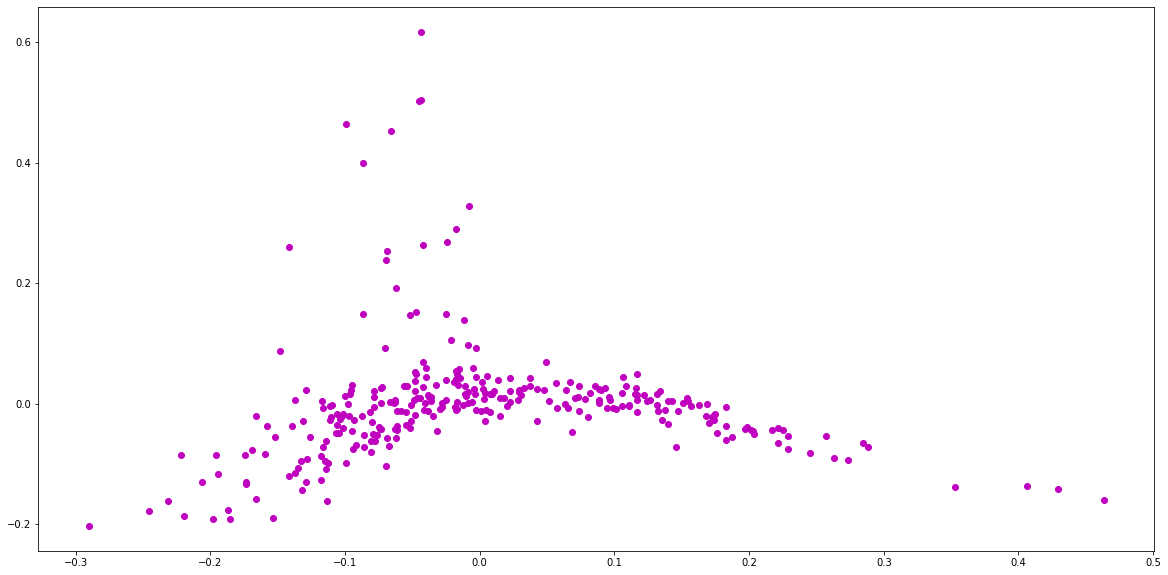

In [550]:
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

In [551]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [552]:
features = vect.get_feature_names()
print (top_feats_in_doc(X, features, 1, 10))

      features     score
0       sexual  0.490274
1  orientation  0.462018
2       xavier  0.219160
3   preference  0.219160
4   homosexual  0.190609
5       cramer  0.173909
6       subset  0.115504
7        allof  0.115504
8       molest  0.115504
9    condition  0.115504


In [553]:
def top_mean_feats(X, features,grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [554]:
print (top_mean_feats(X, features, top_n=10))

     features     score
0         gun  0.016310
1       image  0.013948
2    graphics  0.012728
3      people  0.011460
4        batf  0.011172
5      thanks  0.010200
6         fbi  0.009741
7  government  0.009613
8       files  0.009073
9      format  0.008839


In [555]:
n_clusters = 2
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

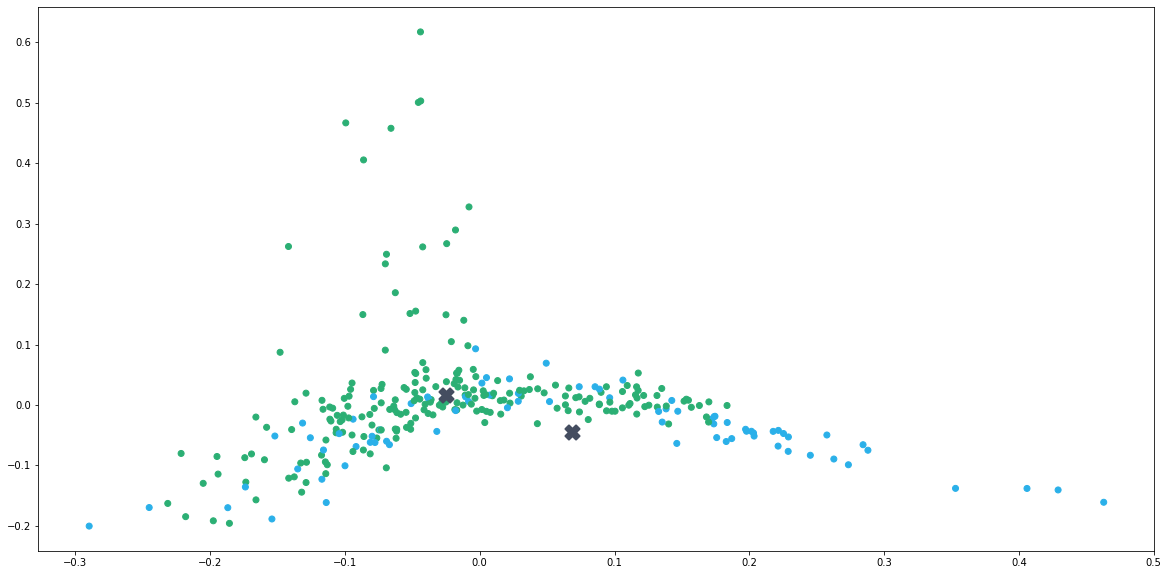

In [556]:
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]
plt.scatter(coords[:, 0], coords[:, 1], c=colors)
# Plot the cluster centers
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
# plt.show()

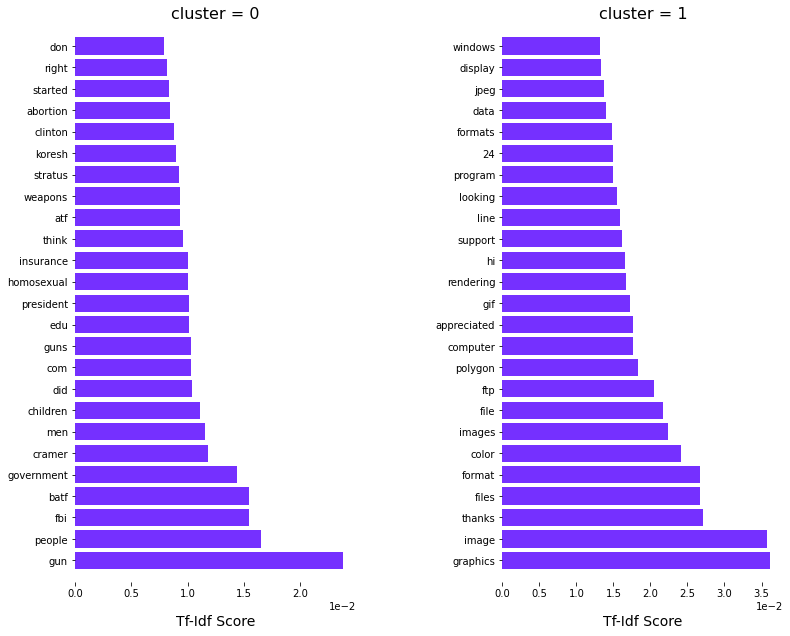

In [416]:
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))

In [383]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs


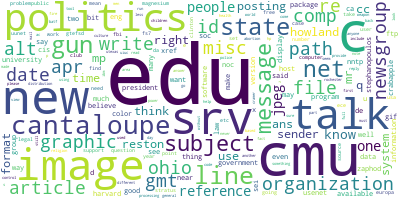

In [318]:
# Visualising the common words in the data
long_string = ' '.join(cleanDocs)
# Create a WordCloud object
#wordcloud = WordCloud(collocations=False,background_color="white", max_words=1000, contour_width=3, contour_color='red')
wordcloud=WordCloud(collocations=False,background_color="white")
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

<BarContainer object of 20 artists>

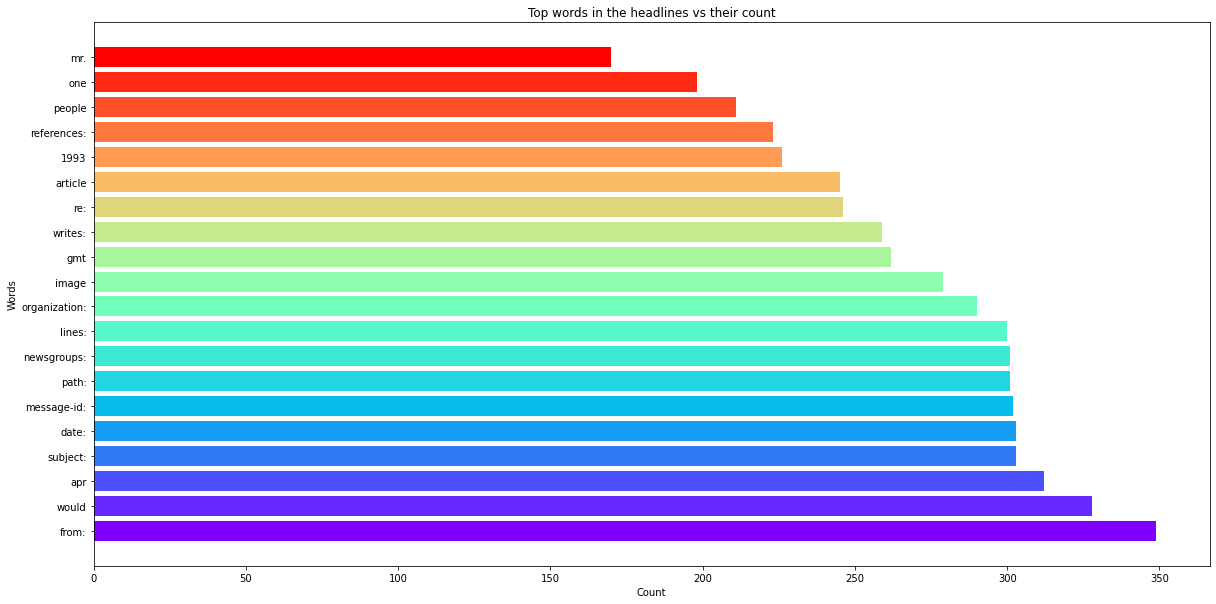

In [320]:
filtered_words = [word for word in long_string.split() if word not in stopwords.words('english')]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(20):
    words.append(letter)
    counts.append(count)

colors = plt.cm.rainbow(np.linspace(0, 1, 20))
plt.rcParams['figure.figsize'] = 20, 10

plt.title('Top words in the headlines vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

In [437]:
vect = TfidfVectorizer(use_idf=True)
docsVector = vect.fit_transform(cleanDocs)
indices = np.argsort(vect.idf_)
features = vect.get_feature_names()
top_n = 20
top_features = [features[i] for i in indices[:top_n]]
top_features

['from',
 'cs',
 'cantaloupe',
 'date',
 'edu',
 'subject',
 'srv',
 'id',
 'message',
 'cmu',
 'path',
 'newsgroups',
 'lines',
 'organization',
 'apr',
 'gmt',
 'news',
 're',
 'references',
 'net']

In [260]:
first_vector_tfidfvectorizer=docsVector[99]
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=vect.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

AttributeError: 'str' object has no attribute 'T'

In [239]:
wcss = []
for j in range (1, 100):
    model = KMeans(n_clusters=j, init='k-means++', max_iter=100, n_init=10, random_state=0)
    model.fit(docsVector)
    wcss.append(model.inertia_)
#     print("Top terms per cluster:")
#     order_centroids = model.cluster_centers_.argsort()[:, ::-1]
#     terms = vect.get_feature_names()
#     for i in range(j):
#         print ("Cluster %d:" % i,)
#         for ind in order_centroids[i, :10]:
#             print (' %s' % terms[ind],)



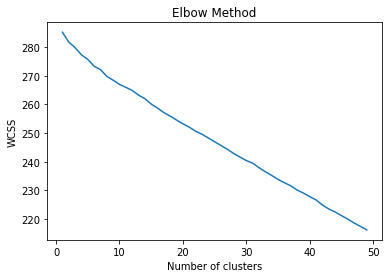

In [240]:
plt.plot(range(1, 100), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [531]:
def kmeans(X, k=5, max_iter=100):
    if isinstance(X, pd.DataFrame):
        X=X.values
    idx=np.random.choice(len(X), k, replace=False)
    centroids=X[idx,:]
    P=np.argmin(distance.cdist(X,centroids,'euclidean'), axis=1)
    for _ in range(max_iter):
        centroids=np.vstack([X[P==i, :].mean(axis=0) for i in range(k)])
        tmp=np.argmin(distance.cdist(X,centroids,'euclidean'), axis=1)
        if np.array_equal(P, tmp):
            break
        P=tmp
    return P

In [532]:
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(emailDf.body)
X.shape

(300, 4434)

In [533]:
X = X.todense()
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

In [536]:
P=Kmeans(X)

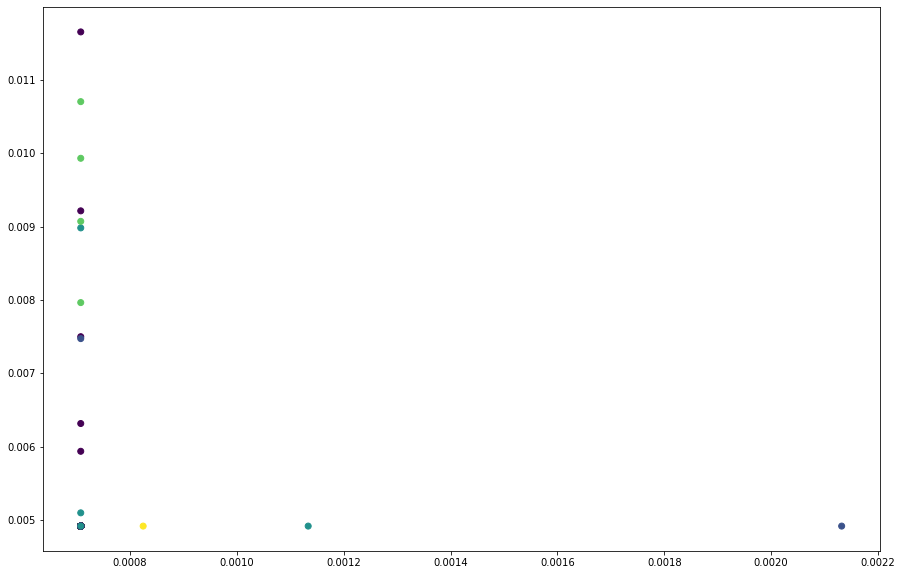

In [537]:
X=sc.inverse_transform(X)
plt.figure(figsize=(15,10))
plt.scatter(X[:,0],X[:,1],c=P)
plt.show()